Menilai Buku Dengan Sampulnya

1. Importing Package

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from cv2 import GaussianBlur, equalizeHist, cvtColor, COLOR_RGB2HSV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin 
from skimage.feature import hog, local_binary_pattern
import matplotlib.pyplot as plt

2. Loading Dataset

Column names in the DataFrame:
['1588345297', '1588345297.jpg', 'http://ecx.images-amazon.com/images/I/51l6XIoa3rL.jpg', 'With Schwarzkopf: Life Lessons of The Bear', 'Gus Lee', '1', 'Biographies & Memoirs']
Training data shape: (51299, 7)
Testing data shape: (5699, 7)

Training dataset columns:
['1588345297', '1588345297.jpg', 'http://ecx.images-amazon.com/images/I/51l6XIoa3rL.jpg', 'With Schwarzkopf: Life Lessons of The Bear', 'Gus Lee', '1', 'Biographies & Memoirs']

First few rows of the DataFrame:
   1588345297  1588345297.jpg  \
0  1404803335  1404803335.jpg   
1  1446276082  1446276082.jpg   
2  1491522666  1491522666.jpg   
3   970096410  0970096410.jpg   
4  8436808053  8436808053.jpg   

  http://ecx.images-amazon.com/images/I/51l6XIoa3rL.jpg  \
0  http://ecx.images-amazon.com/images/I/51UJnL3T...      
1  http://ecx.images-amazon.com/images/I/51MGUKhk...      
2  http://ecx.images-amazon.com/images/I/51qKvjsi...      
3  http://ecx.images-amazon.com/images/I/51qoUENb...     

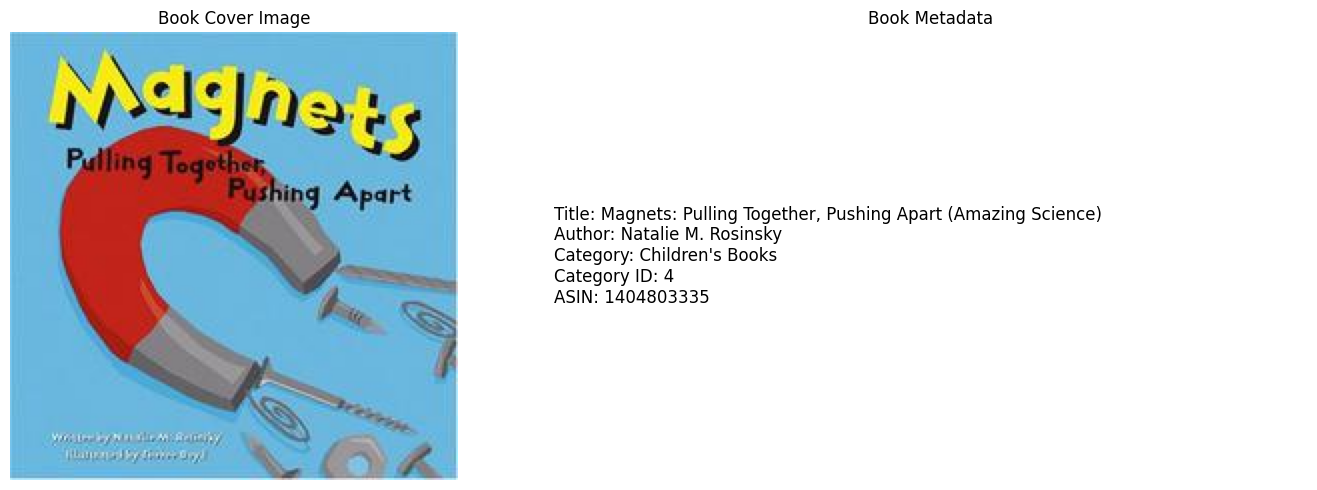


Test sample:


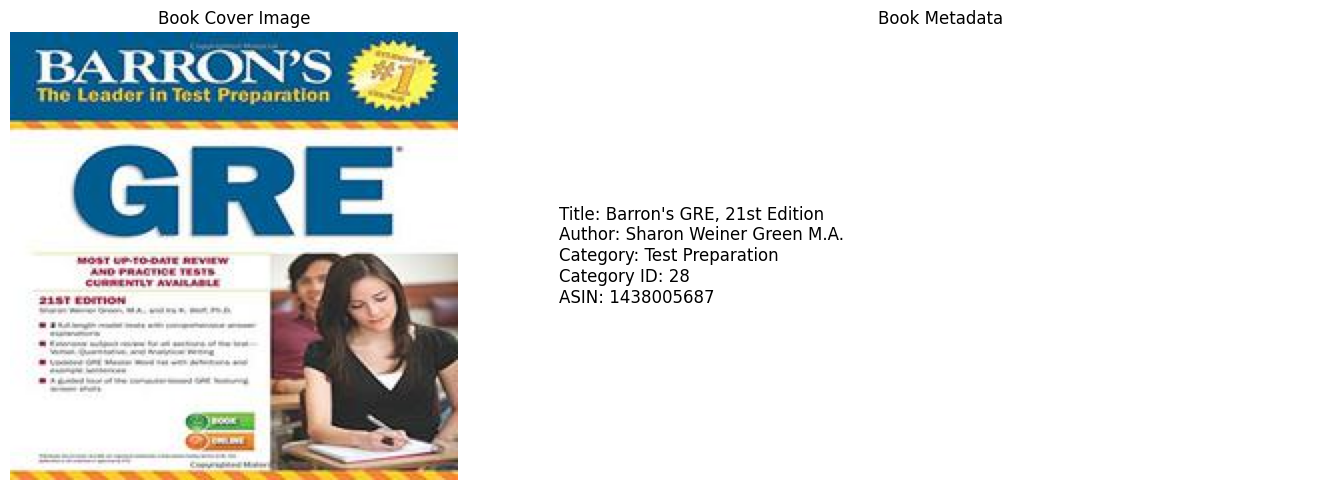


First 5 rows of training data:
   1588345297                                                                                With Schwarzkopf: Life Lessons of The Bear              Gus Lee         Biographies & Memoirs
0  1404803335                                                                Magnets: Pulling Together, Pushing Apart (Amazing Science)  Natalie M. Rosinsky              Children's Books
1  1446276082                                                                  Energy Security (SAGE Library of International Security)                  NaN  Engineering & Transportation
2  1491522666                                                                              An Amish Gathering: Life in Lancaster County         Beth Wiseman      Christian Books & Bibles
4  8436808053  Como vencer el insomnio. Tecnicas, reglas y consejos practicos para dormir mejor (BIBLIOTECA PRACTICA) (Spanish Edition)      Choliz Montanes     Health, Fitness & Dieting
5  1848291388                    

In [2]:
try:
    # First try with utf-8
    df = pd.read_csv('book30-listing-train.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        # Try with latin-1
        df = pd.read_csv('book30-listing-train.csv', encoding='latin-1')
    except:
        # If that fails, try with cp1252 (Windows default)
        df = pd.read_csv('book30-listing-train.csv', encoding='cp1252')
        
print("Column names in the DataFrame:")
print(df.columns.tolist())

# Function to load images with proper column name
def load_images_from_folder(df, image_folder='224x224'):
    images = []
    valid_indices = []
    
    # Print first few rows to debug
    print("\nFirst few rows of the DataFrame:")
    print(df.head())
    
    for idx, row in df.iterrows():
        # Use the correct column name from df.columns
        asin = row[df.columns[0]]  # Assuming ASIN is the first column
        image_path = os.path.join(image_folder, f"{asin}.jpg")
        
        if os.path.exists(image_path):
            try:
                img = Image.open(image_path)
                img_array = np.array(img)
                images.append(img_array)
                valid_indices.append(idx)
            except Exception as e:
                print(f"Error loading image {image_path}: {str(e)}")
    
    return np.array(images), df.iloc[valid_indices]

# Load both training and testing CSV data
def load_dataset(train_csv='book30-listing-train.csv', test_csv='book30-listing-test.csv'):
    # Load training data
    try:
        df_train = pd.read_csv(train_csv, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            df_train = pd.read_csv(train_csv, encoding='latin-1')
        except:
            df_train = pd.read_csv(train_csv, encoding='cp1252')
    
    # Load testing data
    try:
        df_test = pd.read_csv(test_csv, encoding='utf-8')
    except UnicodeDecodeError:
        try:
            df_test = pd.read_csv(test_csv, encoding='latin-1')
        except:
            df_test = pd.read_csv(test_csv, encoding='cp1252')
    
    print(f"Training data shape: {df_train.shape}")
    print(f"Testing data shape: {df_test.shape}")
    return df_train, df_test

# Load both datasets
df_train, df_test = load_dataset()

# Print column names to debug
print("\nTraining dataset columns:")
print(df_train.columns.tolist())

# Load images for both training and testing
X_train_images, y_train_df = load_images_from_folder(df_train)
X_test_images, y_test_df = load_images_from_folder(df_test)

# Use column index directly since we know category ID is in column 5
# And ensure column names match between train and test
y_train = y_train_df.iloc[:, 5].values  # Category ID column
y_test = y_test_df.iloc[:, 5].values    # Category ID column

# Add debug information
print(f"\nUnique categories in training set: {np.unique(y_train)}")
print(f"Unique categories in test set: {np.unique(y_test)}")

# Visualization code with column indices instead of names
def visualize_sample(X_images, df_data, index=0):
    plt.figure(figsize=(15, 5))
    
    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(X_images[index])
    plt.axis('off')
    plt.title('Book Cover Image')
    
    # Display the metadata
    plt.subplot(1, 2, 2)
    plt.axis('off')
    metadata = [
        f"Title: {df_data.iloc[index, 3]}",    # Title column
        f"Author: {df_data.iloc[index, 4]}",   # Author column
        f"Category: {df_data.iloc[index, 6]}",  # Category name column
        f"Category ID: {df_data.iloc[index, 5]}", # Category ID column
        f"ASIN: {df_data.iloc[index, 0]}"      # ASIN column
    ]
    plt.text(0, 0.5, '\n'.join(metadata), fontsize=12, verticalalignment='center')
    plt.title('Book Metadata')
    
    plt.tight_layout()
    plt.show()

# Visualize a sample from training set
print("Training sample:")
visualize_sample(X_train_images, y_train_df)

# Visualize a sample from test set
print("\nTest sample:")
visualize_sample(X_test_images, y_test_df)

# Print first few rows of both datasets
print("\nFirst 5 rows of training data:")
print(y_train_df.iloc[:5, [0,3,4,6]].to_string())
print("\nFirst 5 rows of test data:")
print(y_test_df.iloc[:5, [0,3,4,6]].to_string())

3. Image Preprocessing

In [ ]:
class ImagePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, blur_kernel=(5,5)):
        self.blur_kernel = blur_kernel
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        processed_images = []
        
        for img in X:
            # Apply Gaussian blur
            blurred = GaussianBlur(img, self.blur_kernel, 0)
            
            # Convert to HSV
            hsv = cvtColor(blurred, COLOR_RGB2HSV)
            
            # Apply histogram equalization to V channel
            hsv[:,:,2] = equalizeHist(hsv[:,:,2])
            
            # Normalize and flatten
            features = hsv.reshape(-1) / 255.0
            
            processed_images.append(features)
            
        return np.array(processed_images)

# Create preprocessed datasets with optimized memory usage
preprocessor = ImagePreprocessor()
X_train_images = preprocessor.fit_transform(X_train_images)
X_test_images = preprocessor.transform(X_test_images)

# Visualize the preprocessing steps
def visualize_preprocessing(image):    
    plt.figure(figsize=(15, 5))
    
    # Original
    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original')
    plt.axis('off')
    
    # After Gaussian blur
    plt.subplot(1, 4, 2)
    blurred = GaussianBlur(image, (5,5), 0)
    plt.imshow(blurred)
    plt.title('Gaussian Blur')
    plt.axis('off')
    
    # After HSV conversion
    plt.subplot(1, 4, 3)
    hsv = cvtColor(blurred, COLOR_RGB2HSV)
    plt.imshow(hsv)
    plt.title('HSV')
    plt.axis('off')
    
    # After histogram equalization
    plt.subplot(1, 4, 4)
    hsv[:,:,2] = equalizeHist(hsv[:,:,2])
    plt.imshow(hsv)
    plt.title('Hist Equalization')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize preprocessing on first training image
print("Preprocessing steps visualization:")
visualize_preprocessing(X_train_images[0])

print("Processed data shapes:")
print(f"Training: {X_train_images.shape}")
print(f"Testing: {X_test_images.shape}")

MemoryError: Unable to allocate 1.15 MiB for an array with shape (150528,) and data type float64